In [23]:
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBClassifier 
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, precision_score, recall_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder 

In [3]:
df = pd.read_csv('../data/clean_HR_Analytics.csv')

In [6]:
target = "Attrition"
X = df.drop(columns=target)
y = df[target]

In [7]:
# encode the target 
label = LabelEncoder()
y = label.fit_transform(y)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
pipeline = make_pipeline(
    OrdinalEncoder(),
    StandardScaler(),
    XGBClassifier()
)

In [10]:
params = {
    'xgbclassifier__n_estimators': range(100, 301, 100),
    'xgbclassifier__max_depth': range(3, 8, 2),
    'xgbclassifier__learning_rate': [0.1, 0.01, 0.001]
}
params

{'xgbclassifier__n_estimators': range(100, 301, 100),
 'xgbclassifier__max_depth': range(3, 8, 2),
 'xgbclassifier__learning_rate': [0.1, 0.01, 0.001]}

In [11]:
model = GridSearchCV(
    pipeline,
    param_grid=params,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)
model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                                       ('standardscaler', StandardScaler()),
                                       ('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                     

In [12]:
# train the model
model.fit(X, y)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                                       ('standardscaler', StandardScaler()),
                                       ('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                     

In [13]:
# Extract the best hyperparameters
model.best_params_

{'xgbclassifier__learning_rate': 0.1,
 'xgbclassifier__max_depth': 7,
 'xgbclassifier__n_estimators': 300}

### Evaluate

In [14]:
train_acc = model.score(X_train, y_train)
test_acc = model.score(X_test, y_test)

print("Training Accuracy: ", round(train_acc, 2))
print("Test Accuracy: ", round(test_acc, 2))

Training Accuracy:  1.0
Test Accuracy:  1.0


### Plot Confusion Matrix

In [15]:
# generate the confusion matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm

array([[255,   0],
       [  0,  39]])

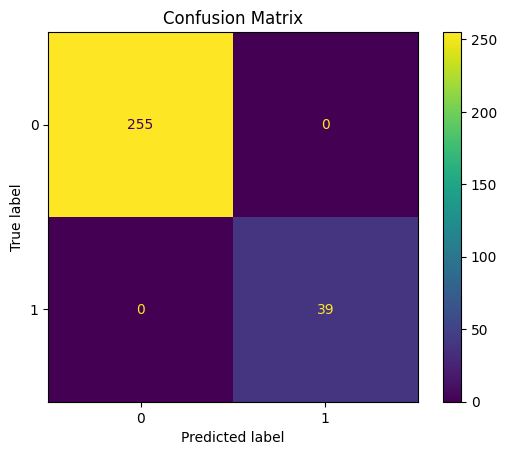

In [16]:
#Create the ConfusionMatrixDisplay object
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

# plot the confusion matrix
cm_display.plot()  
plt.title("Confusion Matrix");
plt.savefig('../reports/confusion_matrix_XGBjpg')

In [20]:
model_f1_score = f1_score(y_test, y_pred)
print("f1_score: ", model_f1_score)

f1_score:  1.0


In [21]:
model_precision = precision_score(y_test, y_pred)
print("Precsion: ", model_precision)

Precsion:  1.0


In [22]:
model_recall = recall_score(y_test, y_pred)
print("Recall: ", model_recall)

Recall:  1.0


### Communicate

In [36]:
# get the feature names 
features = model.best_estimator_.named_steps["ordinalencoder"].get_feature_names_out()
# Extract the importances from model
importances = model.best_estimator_.named_steps["xgbclassifier"].feature_importances_
# create a series
features_imp = pd.Series(importances, index=features).sort_values()

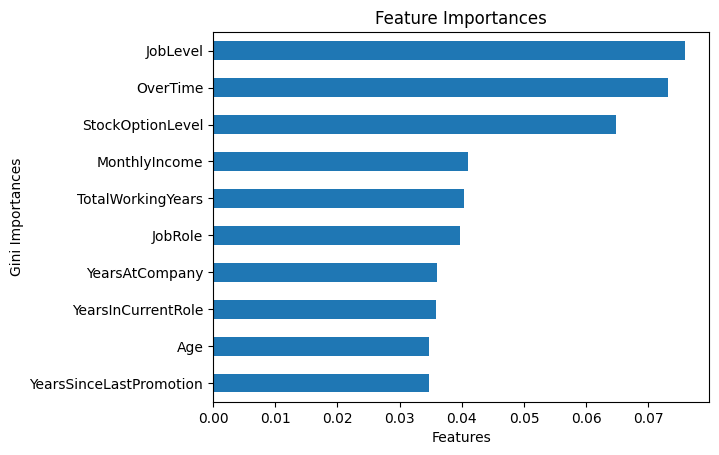

In [38]:
features_imp.tail(10).plot(kind="barh")
plt.xlabel("Features")
plt.ylabel("Gini Importances")
plt.title("Feature Importances")
plt.savefig('../reports/Importances_features_xgb.jpg');

#### Save the Model

In [40]:
timestamp = pd.Timestamp.now().replace(microsecond=0).isoformat()
file_path = os.path.join('../models', f'{timestamp}_XGB.pkl')
with open(file_path, 'wb') as f:
    pickle.dump(model, f)